# Poisson distribution

This models (estimates) the number of events (x) that occur in a fixed interval of time or space, assuming events occur at a constant average rate (λ) and are independent of the time of the last event.

**Example**

Exclusive vines import Argentinian wine into Australia. They've begun advertising on Facebook to direct traffic to their website where customers can order wine online. The number of click-through sales from the ad is poisson distributed with a mean of 12 click-through sales per day.

Find the probability of getting:

a) Exactly 10 click-through sales in the first day, P(X=10)

b) At least 10 click-through sales in the first day, P(X>=10) 

c) More than one sale in the first hour, P(X>1)

d) Is poisson distribution appropriate for this scenario in reality?

Where lambda = 12

$$ P(X=x) = \frac{\lambda^x e^{-\lambda}}{x!}$$


In [161]:
import math as m
from scipy import stats

lam = 12

A = ((lam**10) * m.exp(-lam))/m.factorial(10)
print('Question A:', round((A*100), 2), '%')

#this is because P(X>=10) = 1 - P(X<=9)
B = 1 - stats.poisson.cdf(9, mu=lam)
print('Question B:', round((B*100), 2), '%')

## C

lam_per_hr = lam/24 #this becomes our new lam for this question
C = 1-stats.poisson.cdf(1, mu=lam_per_hr)
print('The probability of getting more than one click through sale in the first hour is:', round((C*100),2), '%')

Question A: 10.48 %
Question B: 75.76 %
The probability of getting more than one click through sale in the first hour is: 9.02 %


**Question D:**

In reality, it is not a poisson distribution because the average click through rate for this ad will differ between time intervals. For example, this ad has been uploaded unto facebook, at different times of the day the average click on that ad will be vastly different. The click through rate at 1pm is not the same at 1am. Regardless, poisson distribution still helps to give us a picture concerning what is going on.

## Case study

**Problem statement**: estimate emergency calls at a 911 center.

**Background**: I am managing a 911 call center and I would like to estimate how many emergency calls I can expect to receive during different hours of the day.

Can we estimate the number of emergency calls that the 911 call center may receive in a given time period?

If yes, this information can help in resource allocation, staffing and capacity planning.

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats
from scipy.stats import poisson

In [35]:
df = pd.read_csv('Data/911.csv')
df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


### Data dictionary

| Variable   | Description                                   |
|------------|-----------------------------------------------|
| lat        | Latitude                     |
| lng        | Longitude                    |
| desc       | Description of the Emergency Call |
| zip        | Zipcode                      |
| title      | Title                        |
| timeStamp  | YYYY-MM-DD HH:MM:SS         |
| twp        | Township                     |
| addr       | Address                      |
| e          | Dummy variable (always 1)   |


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663522 entries, 0 to 663521
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   lat        663522 non-null  float64
 1   lng        663522 non-null  float64
 2   desc       663522 non-null  object 
 3   zip        583323 non-null  float64
 4   title      663522 non-null  object 
 5   timeStamp  663522 non-null  object 
 6   twp        663229 non-null  object 
 7   addr       663522 non-null  object 
 8   e          663522 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 45.6+ MB


We have significant historical data (over 600,000 data points)we can use to estimate the calls at the emergency centre.

In [37]:
#converting the timestamp column from object to datetime

df['timeStamp'] = pd.to_datetime(df['timeStamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663522 entries, 0 to 663521
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   lat        663522 non-null  float64       
 1   lng        663522 non-null  float64       
 2   desc       663522 non-null  object        
 3   zip        583323 non-null  float64       
 4   title      663522 non-null  object        
 5   timeStamp  663522 non-null  datetime64[ns]
 6   twp        663229 non-null  object        
 7   addr       663522 non-null  object        
 8   e          663522 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 45.6+ MB


### Carry out some Exploratory data analysis to understand the data and answer some questions

1. Which are the top townships for calls?
2. How many unique title (subject) cases do we have?
3. What is the reason for most calls?
4. From where did we have the most calls?

In [38]:
#the 10 top townships for calls

df['twp'].value_counts().head(10)

twp
LOWER MERION        55490
ABINGTON            39947
NORRISTOWN          37633
UPPER MERION        36010
CHELTENHAM          30574
POTTSTOWN           27387
UPPER MORELAND      22932
LOWER PROVIDENCE    22476
PLYMOUTH            20116
UPPER DUBLIN        18862
Name: count, dtype: int64

In [39]:
#number of unique subject cases
#df['title'].unique(), 
df['title'].nunique()

148

In [40]:
#reason for most of the calls

df['title'].value_counts().head(5)

title
Traffic: VEHICLE ACCIDENT -    148372
Traffic: DISABLED VEHICLE -     47909
Fire: FIRE ALARM                38336
EMS: FALL VICTIM                34676
EMS: RESPIRATORY EMERGENCY      34248
Name: count, dtype: int64

In [41]:
#the area with the most calls

df['addr'].value_counts().head()

addr
SHANNONDELL DR & SHANNONDELL BLVD    7285
MAIN ST & OLD SUMNEYTOWN PIKE        2576
THE FAIRWAY  & RYDAL RD              1986
EAGLEVILLE RD & SUNDERLAND DR        1618
EVERGREEN RD & W LIGHTCAP RD         1591
Name: count, dtype: int64

### How many calls do we get per day per hour?

In [42]:
#extracting the hour and date

df['hour'] = df['timeStamp'].dt.hour
df['date'] = df['timeStamp'].dt.strftime('%Y-%m-%d')
df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e,hour,date
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1,17,2015-12-10
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1,17,2015-12-10
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1,14,2015-12-10
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1,16,2015-12-10
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1,16,2015-12-10


In [160]:
df['date'].min(), df['date'].max()

('2015-12-10', '2020-07-29')

In [43]:
#group based on date and hour

grouped_df = df.groupby(['date', 'hour'])
grouped_df.get_group(name=('2015-12-10', 16))

,lat,lng,desc,zip,title,timeStamp,twp,addr,e,hour,date
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1,16,2015-12-10
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1,16,2015-12-10
6,40.182111,-75.127795,LAUREL AVE & OAKDALE AVE; HORSHAM; Station 35...,19044.0,EMS: NAUSEA/VOMITING,2015-12-10 16:46:48,HORSHAM,LAUREL AVE & OAKDALE AVE,1,16,2015-12-10
7,40.217286,-75.405182,COLLEGEVILLE RD & LYWISKI RD; SKIPPACK; Stati...,19426.0,EMS: RESPIRATORY EMERGENCY,2015-12-10 16:17:05,SKIPPACK,COLLEGEVILLE RD & LYWISKI RD,1,16,2015-12-10
8,40.289027,-75.399590,MAIN ST & OLD SUMNEYTOWN PIKE; LOWER SALFORD;...,19438.0,EMS: SYNCOPAL EPISODE,2015-12-10 16:51:42,LOWER SALFORD,MAIN ST & OLD SUMNEYTOWN PIKE,1,16,2015-12-10
11,40.084161,-75.308386,BROOK RD & COLWELL LN; PLYMOUTH; 2015-12-10 @ ...,19428.0,Traffic: VEHICLE ACCIDENT -,2015-12-10 16:32:10,PLYMOUTH,BROOK RD & COLWELL LN,1,16,2015-12-10


In [44]:
grouped_df.first()

lat        lng  \
date       hour                         
2015-12-10 14    40.121182 -75.351975   
           15    40.253473 -75.283245   
           16    40.116153 -75.343513   
           17    40.297876 -75.581294   
           18    40.143326 -75.422819   
...                    ...        ...   
2020-07-29 11    40.310213 -75.592882   
           12    40.106664 -75.108347   
           13    40.085921 -75.357623   
           14    40.251174 -75.643975   
           15    40.248522 -75.286242   

                                                              desc      zip  \
date       hour                                                               
2015-12-10 14    HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...  19401.0   
           15    CANNON AVE & W 9TH ST;  LANSDALE; Station 345;...  19446.0   
           16    AIRY ST & SWEDE ST;  NORRISTOWN; Station 308A;...  19401.0   
           17    REINDEER CT & DEAD END;  NEW HANOVER; Station ...  19525.0   
           18    RT422  & PAWLINGS RD OVERPASS; LOWER PROVIDENC...  19403.0   
...                                                            ...      ...   
2020-07-29 11    FAWN DR & MIDDLE CREEK RD;  NEW HANOVER; Stati...  19525.0   
           12    LINDSAY LN & SUSQUEHANNA RD; ABINGTON; 2020-07...  19046.0   
           13    S HENDERSON RD & E CHURCH RD; UPPER MERION; 20...  19406.0   
           14    JEFFERSON AVE & N EVANS ST; POTTSTOWN; 2020-07...  19464.0   
           15    5TH ST & UNNAMED ALY;  LANSDALE; Station 345; ...  19446.0   

                                         title           timeStamp  \
date       hour                                                      
2015-12-10 14              Fire: GAS-ODOR/LEAK 2015-12-10 14:39:21   
           15                 EMS: HEAD INJURY 2015-12-10 15:39:04   
           16           EMS: CARDIAC EMERGENCY 2015-12-10 16:47:36   
           17           EMS: BACK PAINS/INJURY 2015-12-10 17:10:52   
           18      Traffic: DISABLED VEHICLE - 2015-12-10 18:00:38   
...                                        ...                 ...   
2020-07-29 11              EMS: CARDIAC ARREST 2020-07-29 11:00:15   
           12    Fire: ELECTRICAL FIRE OUTSIDE 2020-07-29 12:09:15   
           13      Traffic: VEHICLE ACCIDENT - 2020-07-29 13:05:50   
           14      Traffic: VEHICLE ACCIDENT - 2020-07-29 14:06:14   
           15            EMS: GENERAL WEAKNESS 2020-07-29 15:09:05   

                              twp                           addr  e  
date       hour                                                      
2015-12-10 14          NORRISTOWN                       HAWS AVE  1  
           15            LANSDALE          CANNON AVE & W 9TH ST  1  
           16          NORRISTOWN             AIRY ST & SWEDE ST  1  
           17         NEW HANOVER         REINDEER CT & DEAD END  1  
           18    LOWER PROVIDENCE  RT422  & PAWLINGS RD OVERPASS  1  
...                           ...                            ... ..  
2020-07-29 11         NEW HANOVER      FAWN DR & MIDDLE CREEK RD  1  
           12            ABINGTON    LINDSAY LN & SUSQUEHANNA RD  1  
           13        UPPER MERION   S HENDERSON RD & E CHURCH RD  1  
           14           POTTSTOWN     JEFFERSON AVE & N EVANS ST  1  
           15            LANSDALE           5TH ST & UNNAMED ALY  1  

[40546 rows x 9 columns]

In [45]:
grouped_df['timeStamp'].count()

date        hour
2015-12-10  14       1
            15       1
            16       6
            17      16
            18      26
                    ..
2020-07-29  11      17
            12      15
            13      22
            14      16
            15      26
Name: timeStamp, Length: 40546, dtype: int64

In [46]:
grouped_df['timeStamp'].count().reset_index()

,date,hour,timeStamp
0,2015-12-10,14,1
1,2015-12-10,15,1
2,2015-12-10,16,6
3,2015-12-10,17,16
4,2015-12-10,18,26
...,...,...,...
40541,2020-07-29,11,17
40542,2020-07-29,12,15
40543,2020-07-29,13,22
40544,2020-07-29,14,16


In [47]:
calls = grouped_df['timeStamp'].count().reset_index()
calls.head()

,date,hour,timeStamp
0,2015-12-10,14,1
1,2015-12-10,15,1
2,2015-12-10,16,6
3,2015-12-10,17,16
4,2015-12-10,18,26


In [48]:
calls.columns = ['date', 'hour', 'calls']
calls.head(10)

,date,hour,calls
0,2015-12-10,14,1
1,2015-12-10,15,1
2,2015-12-10,16,6
3,2015-12-10,17,16
4,2015-12-10,18,26
5,2015-12-10,19,20
6,2015-12-10,20,15
7,2015-12-10,21,11
8,2015-12-10,22,10
9,2015-12-10,23,8


In [56]:
#using a pivot table

report = pd.pivot_table(data = calls,
              index='date',
              columns='hour',
              values='calls')
report

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2015-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,6.0,16.0,26.0,20.0,15.0,11.0,10.0,8.0
2015-12-11,3.0,4.0,4.0,9.0,6.0,5.0,10.0,11.0,29.0,11.0,...,23.0,28.0,27.0,39.0,24.0,32.0,11.0,12.0,16.0,7.0
2015-12-12,7.0,5.0,5.0,11.0,5.0,11.0,3.0,14.0,5.0,12.0,...,20.0,28.0,30.0,22.0,24.0,37.0,9.0,29.0,21.0,19.0
2015-12-13,9.0,5.0,5.0,8.0,2.0,4.0,8.0,13.0,14.0,11.0,...,18.0,17.0,14.0,22.0,28.0,16.0,14.0,8.0,17.0,6.0
2015-12-14,4.0,11.0,4.0,3.0,4.0,10.0,15.0,27.0,25.0,21.0,...,16.0,28.0,33.0,31.0,38.0,22.0,20.0,19.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-25,16.0,8.0,2.0,8.0,3.0,6.0,5.0,7.0,14.0,14.0,...,19.0,23.0,28.0,18.0,15.0,13.0,10.0,12.0,10.0,9.0
2020-07-26,6.0,7.0,8.0,8.0,6.0,3.0,7.0,6.0,13.0,16.0,...,26.0,13.0,12.0,19.0,18.0,14.0,20.0,15.0,8.0,5.0
2020-07-27,11.0,7.0,4.0,3.0,4.0,10.0,8.0,14.0,10.0,14.0,...,20.0,20.0,19.0,15.0,15.0,10.0,35.0,13.0,8.0,8.0


In [57]:
#there are some null values, let's investigate them

report.isnull().sum()

hour
0      7
1      8
2     17
3     14
4     11
5     11
6      2
7      4
8      1
9      2
10     2
11     3
12     2
13     4
14     1
15     1
16     2
17     2
18     2
19     3
20     2
21     2
22     3
23     4
dtype: int64

In [58]:
report.fillna(0, inplace=True)
report

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2015-12-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,6.0,16.0,26.0,20.0,15.0,11.0,10.0,8.0
2015-12-11,3.0,4.0,4.0,9.0,6.0,5.0,10.0,11.0,29.0,11.0,...,23.0,28.0,27.0,39.0,24.0,32.0,11.0,12.0,16.0,7.0
2015-12-12,7.0,5.0,5.0,11.0,5.0,11.0,3.0,14.0,5.0,12.0,...,20.0,28.0,30.0,22.0,24.0,37.0,9.0,29.0,21.0,19.0
2015-12-13,9.0,5.0,5.0,8.0,2.0,4.0,8.0,13.0,14.0,11.0,...,18.0,17.0,14.0,22.0,28.0,16.0,14.0,8.0,17.0,6.0
2015-12-14,4.0,11.0,4.0,3.0,4.0,10.0,15.0,27.0,25.0,21.0,...,16.0,28.0,33.0,31.0,38.0,22.0,20.0,19.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-25,16.0,8.0,2.0,8.0,3.0,6.0,5.0,7.0,14.0,14.0,...,19.0,23.0,28.0,18.0,15.0,13.0,10.0,12.0,10.0,9.0
2020-07-26,6.0,7.0,8.0,8.0,6.0,3.0,7.0,6.0,13.0,16.0,...,26.0,13.0,12.0,19.0,18.0,14.0,20.0,15.0,8.0,5.0
2020-07-27,11.0,7.0,4.0,3.0,4.0,10.0,8.0,14.0,10.0,14.0,...,20.0,20.0,19.0,15.0,15.0,10.0,35.0,13.0,8.0,8.0


In [59]:
report_reset = report.reset_index()
report_long = pd.melt(report_reset, id_vars=['date'], value_vars=report.columns, var_name='hour', value_name='calls')
report_long

,date,hour,calls
0,2015-12-10,0,0.0
1,2015-12-11,0,3.0
2,2015-12-12,0,7.0
3,2015-12-13,0,9.0
4,2015-12-14,0,4.0
...,...,...,...
40651,2020-07-25,23,9.0
40652,2020-07-26,23,5.0
40653,2020-07-27,23,8.0
40654,2020-07-28,23,9.0


<AxesSubplot:xlabel='hour', ylabel='calls'>

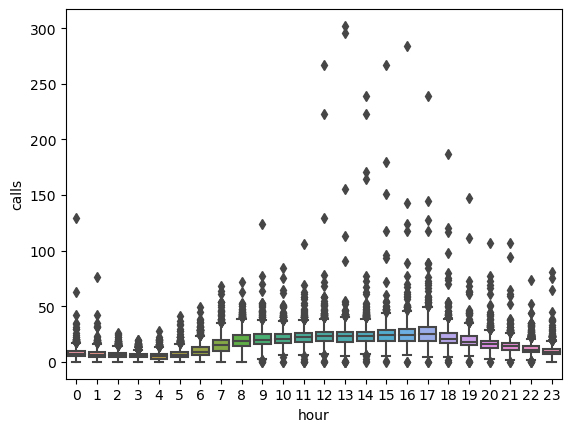

In [60]:
sns.boxplot(x='hour', y='calls', data=report_long)

There is a wider distribution of calls around 12pm to 5pm on average.

In [62]:
report.median()

#the median number of calls per hour.
#this means that we can expect calls above/below this median value

hour
0      7.0
1      6.0
2      6.0
3      5.0
4      5.0
5      6.0
6      9.0
7     15.0
8     19.0
9     20.0
10    21.0
11    22.0
12    23.0
13    23.0
14    23.0
15    24.0
16    24.0
17    25.0
18    21.0
19    18.0
20    16.0
21    14.0
22    11.0
23     9.0
dtype: float64

In [63]:
report.mean()

hour
0      8.183589
1      6.936836
2      6.288666
3      5.600945
4      5.469303
5      6.892562
6     10.164699
7     15.921488
8     19.704841
9     20.942739
10    21.592090
11    22.476978
12    23.670012
13    23.492916
14    23.817001
15    24.948642
16    25.263872
17    26.044274
18    22.031877
19    19.151122
20    16.575561
21    14.556671
22    11.991145
23     9.971665
dtype: float64

<AxesSubplot:xlabel='hour', ylabel='calls'>

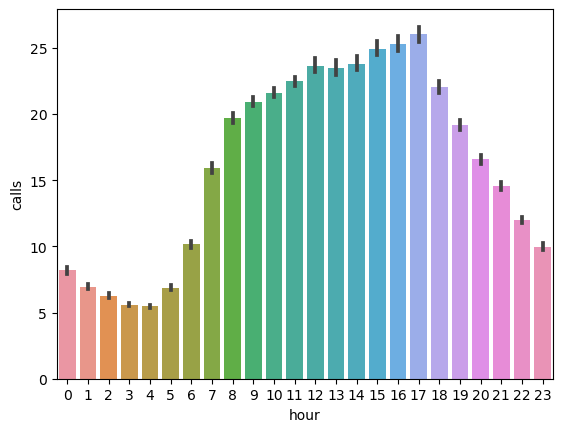

In [68]:
#sns.barplot(data=report, estimator=np.median)
sns.barplot(x='hour', y='calls', data=report_long)

<AxesSubplot:xlabel='hour', ylabel='calls'>

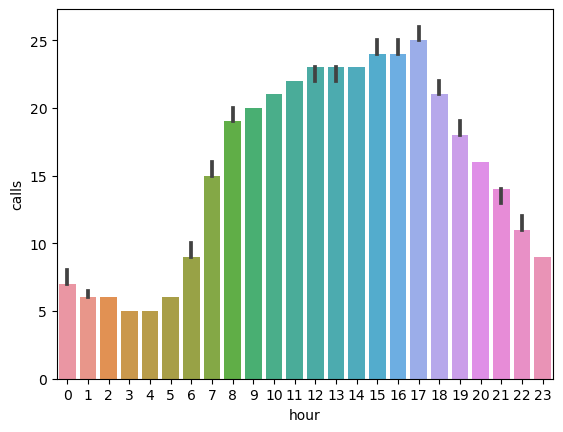

In [71]:
sns.barplot(x='hour', y='calls', data=report_long, estimator=np.median)

The estimator parameter is used to determine the statistical function used to estimate the central tendency of the data. By default, sns.barplot uses the average as the estimator.

From the historical data and the plot above, we can make the following assumptions and observations

1. Our peak time is between 5pm and 6pm. 

2. Assuming that the call every hour of the day comes at a constant rate, i.e, during 5pm to 6pm we are getting 20,23, 26, 30, etc, across multiple days. Lambda is the median number of calls across all the days during 5pm to 6pm.

2. We see that we receive about 25 emergency calls per hour during peak times (lam = 25)

**Next, our objective:**

We want to use the poisson distribution to estimate the probabilities of different numbers of emergency calls arriving in the next hour.

In [72]:
report.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2015-12-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,6.0,16.0,26.0,20.0,15.0,11.0,10.0,8.0
2015-12-11,3.0,4.0,4.0,9.0,6.0,5.0,10.0,11.0,29.0,11.0,...,23.0,28.0,27.0,39.0,24.0,32.0,11.0,12.0,16.0,7.0
2015-12-12,7.0,5.0,5.0,11.0,5.0,11.0,3.0,14.0,5.0,12.0,...,20.0,28.0,30.0,22.0,24.0,37.0,9.0,29.0,21.0,19.0
2015-12-13,9.0,5.0,5.0,8.0,2.0,4.0,8.0,13.0,14.0,11.0,...,18.0,17.0,14.0,22.0,28.0,16.0,14.0,8.0,17.0,6.0
2015-12-14,4.0,11.0,4.0,3.0,4.0,10.0,15.0,27.0,25.0,21.0,...,16.0,28.0,33.0,31.0,38.0,22.0,20.0,19.0,10.0,10.0


In [73]:
#let's model the estimates for the 7th hour of the day

hour_of_the_day = int(input('Enter the hour:'))

while hour_of_the_day < 0 or hour_of_the_day>23:
    print('Invalid input! \n Input should be an integer between 0 and 23')
    hour_of_the_day = int(input('Enter the hour:'))
else:
    print('Input accepted')
    

Enter the hour:7
Input accepted


In [74]:
report[hour_of_the_day]

date
2015-12-10     0.0
2015-12-11    11.0
2015-12-12    14.0
2015-12-13    13.0
2015-12-14    27.0
              ... 
2020-07-25     7.0
2020-07-26     6.0
2020-07-27    14.0
2020-07-28    17.0
2020-07-29    13.0
Name: 7, Length: 1694, dtype: float64

In [75]:
report[hour_of_the_day].value_counts()

7
16.0    101
13.0     94
10.0     88
15.0     87
11.0     85
8.0      83
14.0     81
19.0     80
12.0     78
20.0     77
7.0      77
17.0     76
18.0     75
9.0      73
21.0     66
6.0      54
24.0     50
22.0     46
23.0     42
5.0      40
27.0     37
25.0     35
28.0     28
26.0     26
4.0      18
29.0     15
30.0      9
3.0       8
34.0      6
35.0      6
31.0      6
32.0      5
36.0      5
2.0       4
0.0       4
33.0      4
39.0      4
54.0      3
38.0      2
1.0       2
46.0      2
42.0      2
43.0      1
61.0      1
51.0      1
45.0      1
47.0      1
37.0      1
64.0      1
49.0      1
41.0      1
68.0      1
Name: count, dtype: int64

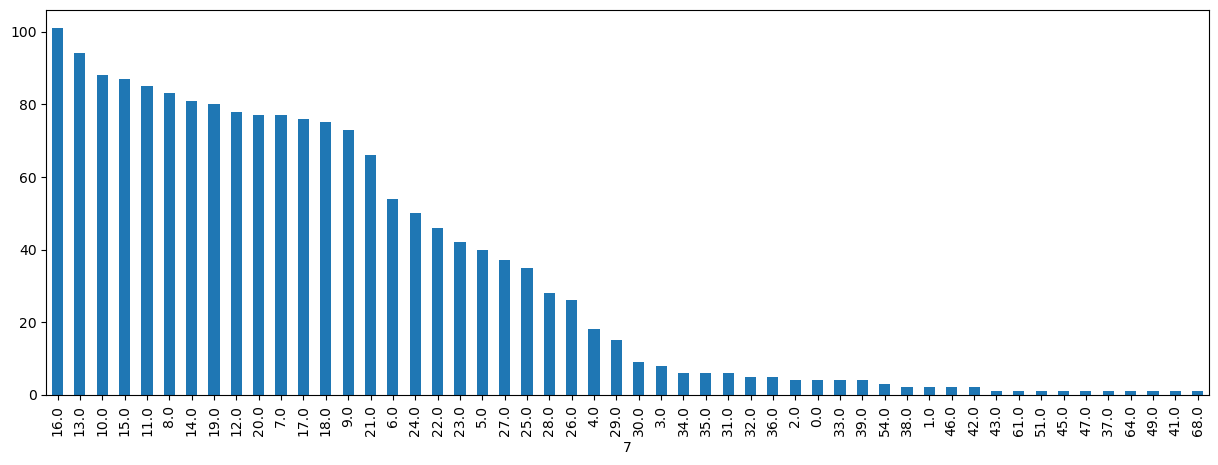

In [98]:
plt.figure(figsize=(15, 5))

report[hour_of_the_day].value_counts().plot(kind='bar')

plt.show()

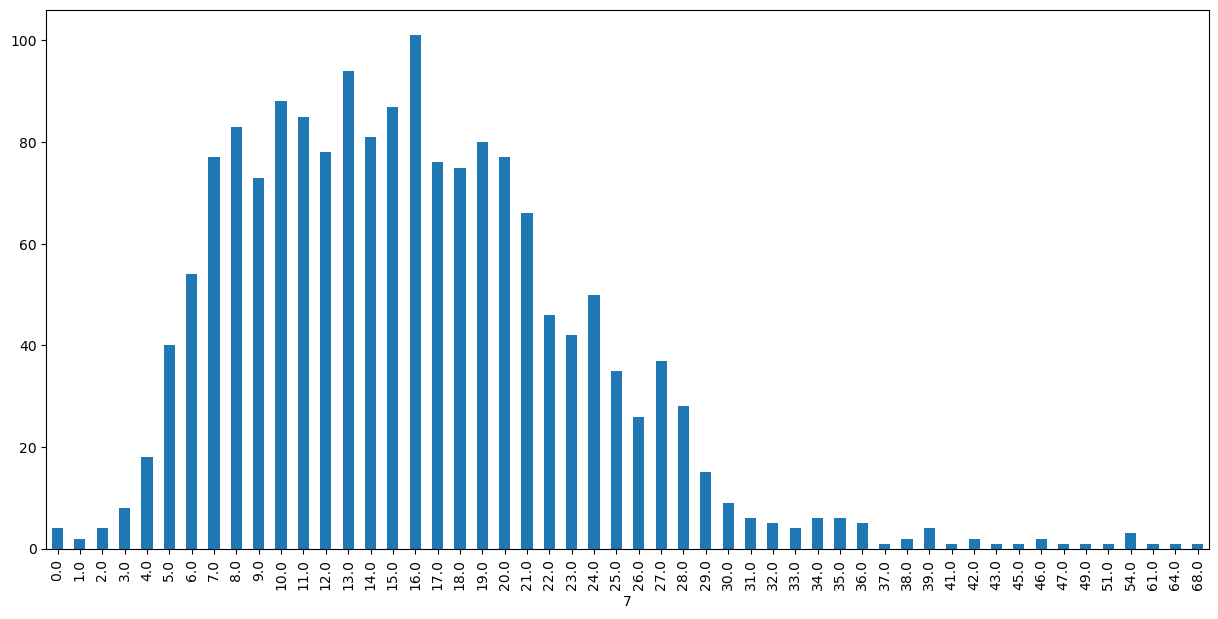

In [99]:
plt.figure(figsize=(15,7))

report[hour_of_the_day].value_counts().sort_index().plot(kind='bar')

plt.show()

We can observe that the poisson distribution is a discrete distribution and right skewed.

In [102]:
#define the average call rate (lambda) for the poisson distribution

lambda_ = report[hour_of_the_day].median()

#define the possible number of emergency calls
min_th = int(lambda_) - 10
max_th = int(lambda_) + 10

num_calls = range(min_th, max_th)

#cal the probabilities for different numbers of calls

estimates = []
for num in num_calls:
    if num>=0:
        estimates.append([num, round(poisson.pmf(num, mu=lambda_), 4)*100])
        
est_df = pd.DataFrame(estimates, columns=['n_calls', 'prob%'])
est_df

,n_calls,prob%
0,5,0.19
1,6,0.48
2,7,1.04
3,8,1.94
4,9,3.24
5,10,4.86
6,11,6.63
7,12,8.29
8,13,9.56
9,14,10.24


This shows us the probability of receiving different number of calls during the 7th hour (7am to 8am) of a day.

In the code above, we use the poisson distribution to estimate the probabilities of different numbers of emergency calls arriving in the next hour. The `mu` parameter is set to the average arrival rate. The loop is used to print out the probability of each possible number of calls.

The code gives us the probabilities of different numbers of emergency calls arriving in the next hour. For example, it can tell us that there is a 10% chance of receiving exactly 25 emergency calls and 15% chance of receiiving exactly 35 calls.

Using this information you can make decisions about how many operators to schedule, how many phone lines to keep open, and how to allocate resources effectively during differen times of the day.

## Putting everything together

Enter the hour:12
Input accepted


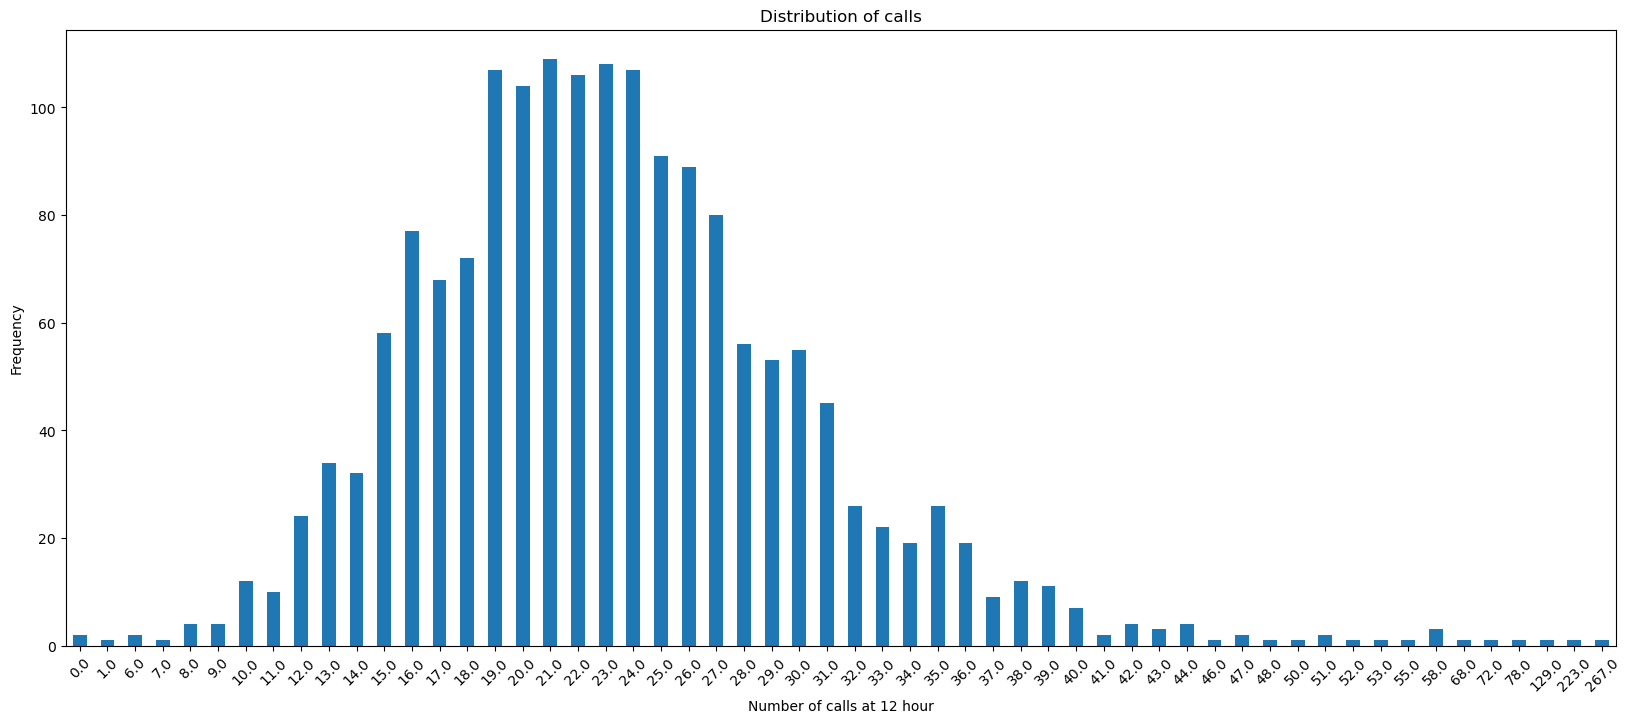

    n_calls  prob%
10       23   8.29
9        22   8.29
11       24   7.94
8        21   7.93
12       25   7.31
7        20   7.24
13       26   6.46
6        19   6.29
14       27   5.51
5        18   5.20
23.0


In [159]:
hour_of_the_day = int(input('Enter the hour:'))

while hour_of_the_day < 0 or hour_of_the_day > 23:
    print('Invalid input! \n Input should be an integer between 0 and 23')
    hour_of_the_day = int(input('Enter the hour:'))
    
else:    
    print('Input accepted')
    
    #First - plot distribution
    fig, ax = plt.subplots(figsize=(20,8))
    ax.set_title('Distribution of calls')
    data = report[hour_of_the_day].value_counts().sort_index().plot(kind='bar', ax=ax)
    
    ax.set_xlabel(f'Number of calls at {hour_of_the_day} hour')
    ax.set_ylabel('Frequency')
    plt.xticks(rotation = 45)
    plt.show()

    
    #Second - return probabilities
    lambda_ = report[hour_of_the_day].median()

    #define the possible number of emergency calls
    min_th = int(lambda_) - 10
    max_th = int(lambda_) + 20

    num_calls = range(min_th, max_th)

    #cal the probabilities for different numbers of calls
    estimates = []
    for num in num_calls:
        if num>=0:
            estimates.append([num, round(poisson.pmf(num, mu=lambda_), 4)*100])
        
    est_df = pd.DataFrame(estimates, columns=['n_calls', 'prob%'])
    
    high_calls = est_df.sort_values(by = 'prob%', ascending=False).head(10)
  
    print(high_calls)
    print(lambda_)